**Identifying PNs that are upstream of KCs**
<br>
These PNs will be used to identify bifuricating paths to the Lateral Horn and Mushroom Body. This script depends on edge lists generated by *generate_updated_adjs.py*. Below are the basic imports required for the script, including notably contools (https://github.com/mwinding/connectome_tools) and python-catmaid (pymaid).

In [ ]:
import pymaid
import contools
import pandas as pd
import numpy as np
from contools import generate_adjs, Celltype_Analyzer, Celltype, Promat

from pymaid_creds import url, name, password, token
from data_settings import pairs_path, data_date

rm = pymaid.CatmaidInstance(url, token, name, password)
pairs = contools.Promat.get_pairs(pairs_path)

# load a-d edges with 1% input threshold
edge_type = 'ad'
edges = pd.read_csv(f'data/edges_threshold/{edge_type}_pairwise-input-threshold-0.01_all-edges_{data_date}.csv', index_col=0)
edges_syn3 = pd.read_csv(f'data/edges_threshold/{edge_type}_pairwise-threshold-3syn_all-edges_{data_date}.csv', index_col=0)

In [2]:
# house-keeping chunk
#####################
# double check for neurons upstream of KCs that aren't included in adjacency matrix
# these will probably want to be added if of interest

KCs = pymaid.get_skids_by_annotation('mw KC')

KC_partners = pymaid.get_partners(KCs)
us_KC_skids = KC_partners[KC_partners.relation=='upstream'].skeleton_id
us_KC_skids = [int(x) for x in us_KC_skids] # pymaid saves skids as str for some reason

adj = pd.read_csv(f'data/adj/ad_{adj_date}.csv', index_col=0)
all_neurons = list(adj.index)

print(f'{len(np.intersect1d(list(us_KC_skids), all_neurons))/len(us_KC_skids)*100:.0f}% of upstream neurons are in matrix')
print('The remainder were inspected manually, most were fragments or partially differentiated neurons')

#neurons_not_in_matrix = list(np.setdiff1d(us_KC_skids, all_neurons))
#pymaid.add_annotations(neurons_not_in_matrix, 'mw not in matrix')

# did find two pairs of potential gustatory PNs
# will add to the adj matrix by including in "mw brain accessory neurons"

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Fetching connectivity table for 222 neurons (pymaid)
INFO  : Done. Found 500 pre-, 936 postsynaptic and 0 gap junction-connected neurons (pymaid)


87% of upstream neurons are in matrix
The remainder were inspected manually, most were fragments or partially differentiated neurons


Identify neurons upstream of KCs with 1% input threshold or 3-synapse threshold (both axo-dendritic)

In [ ]:
# find PNs upstream of KCs

KCs = pymaid.get_skids_by_annotation('mw KC')

# upstream of KCs using 1% input threshold
upstream_KC = Promat.upstream_multihop(edges=edges, sources=KCs, hops=1, pairs=pairs)
upstream_KC = Celltype(name='us-KCs', skids=upstream_KC)

# upstream of KC using 3 syn threshold
upstream_KC_syn3 = Promat.upstream_multihop(edges=edges_syn3, sources=KCs, hops=1, pairs=pairs)
upstream_KC_syn3 = Celltype(name='us-KCs-syn3', skids=upstream_KC_syn3)

# how many PNs and somatosensory PNs are upstream of KCs?
PNs = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs')
PNs_somato = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs-somato')

In [4]:
print(f'Using a 1% input threshold (pairwise):')
print(f'\t{len(np.unique(np.intersect1d(PNs, upstream_KC.skids)))/len(np.unique(PNs))*100:.1f}% of PNs are upstream of KCs')
print(f'\t{len(np.unique(np.intersect1d(PNs_somato, upstream_KC.skids))/len(np.unique(PNs_somato)))*100}% of Somatosensory PNs are upstream of KCs')
print('')
print(f'Using a 3-synapse threshold (pairwise):')
print(f'\t{len(np.unique(np.intersect1d(PNs, upstream_KC_syn3.skids)))/len(np.unique(PNs))*100:.1f}% of PNs are upstream of KCs')
print(f'\t{len(np.unique(np.intersect1d(PNs_somato, upstream_KC_syn3.skids))/len(np.unique(PNs_somato)))*100}% of Somatosensory PNs are upstream of KCs')

Using a 1% input threshold (pairwise):
	34.6% of PNs are upstream of KCs
	0% of Somatosensory PNs are upstream of KCs

Using a 3-synapse threshold (pairwise):
	29.8% of PNs are upstream of KCs
	0% of Somatosensory PNs are upstream of KCs


**Which PNs are upstream of KCs?**
Because no somatosensory PNs were observed, those will be ignored below

In [ ]:
PN_groups = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs', split=True)
PN_groups = [Celltype(name=PN_groups[1][i][3:], skids=PN_groups[0][i]) for i in range(len(PN_groups[0]))] # set up Celltype objects

cts = Celltype_Analyzer(PN_groups)
cts.set_known_types([upstream_KC, upstream_KC_syn3])

In [6]:
print('Fraction of each PN type that are upstream of KCs')
cts.memberships().loc[['us-KCs', 'us-KCs-syn3']]

Fraction of each PN type that are upstream of KCs


,mPN (28),tPN (10),uPN (42),vPN (10),Pdf-LaNs (8),olfactory 2nd_order PN (72),gustatory-external 2nd_order PN (104),gustatory-pharyngeal 2nd_order PN (56),enteric 2nd_order PN (22),thermo-warm 2nd_order PN (8),thermo-cold 2nd_order PN (10),visual 2nd_order PN (18),respiratory 2nd_order PN (4)
us-KCs,0.214286,0.8,1.000000,0.2,0.25,0.694444,0.192308,0.142857,0.0,0.25,0.8,0.222222,0.0
us-KCs-syn3,0.214286,0.6,0.904762,0.2,0.00,0.611111,0.173077,0.142857,0.0,0.25,0.6,0.111111,0.0


Based on these results, I prefer the 1% input threshold. It captures all uPNs as expected and more coverage on other modalities. However, overall it seems fairly comparable

Fraction PNs upstream of KCs


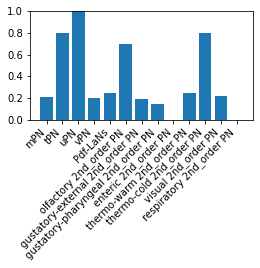

In [7]:
# plot cell types
cts.set_known_types([upstream_KC])
print('Fraction PNs upstream of KCs')
cts.plot_memberships(path='plots/PNs-upstream-KC.pdf', figsize=(4,2), celltype_colors=['tab:blue', 'white'])

In [ ]:

# annotate upstream neurons
pymaid.add_annotations(upstream_KC.skids, 'mw upstream KCs')

# annotate upstream PNs
PNs = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain PNs')
PNs_us_KC = list(np.intersect1d(PNs, upstream_KC.skids))
pymaid.add_annotations(PNs_us_KC, 'mw PNs upstream KCs')


In [11]:
# annotate upstream PN by category
skids, annot_list = Celltype_Analyzer.get_skids_from_meta_annotation('mw brain inputs 2nd_order PN', split=True)
PN_types = [Celltype(annot_list[i], skids[i]) for i in range(len(annot_list))]

# break up us_KC skids into PN categories
PN_us_KCs = [Celltype(PN_types[i].name.replace(' 2nd_order PN', '').replace('mw ', 'mw upstream KCs ') + ' PN', np.intersect1d(PN_types[i].skids, upstream_KC.skids)) for i in range(len(PN_types))]

# annotate neurons
[pymaid.add_annotations(celltype.skids, celltype.name) for celltype in PN_us_KCs if len(celltype.skids)>0]
pymaid.add_meta_annotations([celltype.name for celltype in PN_us_KCs if len(celltype.skids)>0], 'mw upstream KCs PN-types')

INFO  : Searching for: mw brain inputs 2nd_order PN (pymaid)


{'message': 'success',
 'annotations': [{'name': 'mw upstream KCs PN-types',
   'id': 22137613,
   'entities': [22137608, 22137515, 22137587, 22137596, 22137566, 22137599]}],
 'new_annotations': [22137613],
 'existing_annotations': []}

Checked all other non-PN neurons upstream of KCs to make sure no PN-like cells were missed

In [14]:
nonPN = list(np.setdiff1d(upstream_KC.skids, PNs))
print(f'I manually checked these neurons in CATMAID:\n {nonPN}')
print('')
print(f'I found that {[7092086, 4876704]} look morphologically like PNs, but are not listed as PN')

I manually checked these neurons in CATMAID:
 [1869592, 3234817, 4102413, 4152020, 4635057, 4876704, 4926999, 5289042, 6143930, 7092086, 7971031, 7982896, 8138616, 8177199, 8398900, 8932110, 9275210, 9291938, 9445876, 10540188, 11123016, 12948470, 13849557, 15571194, 16485079, 17434825, 19611917, 21664445]

I found that [7092086, 4876704] look like PNs, but are not listed as PN


In [30]:
# explain the putative gustatory pathway

print(f'There is a short pathway from a pair of gustatory-external sensory neurons, {[15716934, 15746421]},\n through {[11821320, 6220384, 5327961, 11184236]}, to {[7092086, 4876704]}')
print(f'Thus, {[7092086, 4876704]} are 3rd-order gustatory-external neurons that appear to be PN-like')
print(f'I have added them to the "mw upstream KCs gustatory-external PN" annotation')

There is a short pathway from a pair of gustatory-external sensory neurons, [15716934, 15746421],
 through [11821320, 6220384, 5327961, 11184236], to [7092086, 4876704]
Thus, [7092086, 4876704] are 3rd-order gustatory-external neurons that appear to be PN-like
I have added them to the "mw upstream KCs gustatory-external PN" annotation


Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/4 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/4 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/4 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Gustatory (Orange) -> Interneuron (Purple) -> PN (Blue)


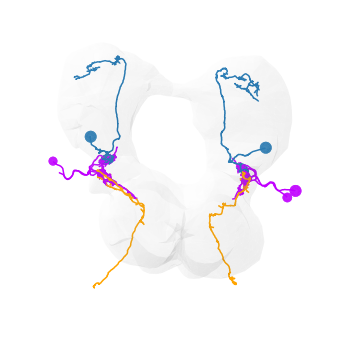

In [33]:
# plot the putative gustatory pathway
import navis 

color1 = 'orange'
color2 = '#C000FF'
color3 = 'tab:blue'


sens = Celltype(name='gustatory sens', skids=[15716934, 15746421], color=color1)
inter = Celltype(name='2nd-order gustatory', skids=[11821320, 6220384, 5327961, 11184236], color=color2)
PN = Celltype(name='3rd-order gustatory PN', skids=[7092086, 4876704], color=color3)

volume = 'PS_Neuropil_manual'
neuropil = pymaid.get_volume(volume)
vol_color = (250, 250, 250, .05)
neuropil.color = vol_color

sens_neurons = pymaid.get_neurons(sens.skids)
inter_neurons = pymaid.get_neurons(inter.skids)
PN_neurons = pymaid.get_neurons(PN.skids)

color=color1
alpha = 1
linewidth=1.5
connectors=False

fig, ax = navis.plot2d([sens_neurons, neuropil], method='3d_complex', color=sens.color, linewidth=linewidth, connectors=connectors, cn_size=2, alpha=alpha)
navis.plot2d([inter_neurons], method='3d_complex', color=inter.color, linewidth=linewidth, connectors=connectors, cn_size=2, alpha=alpha, ax=ax)
navis.plot2d([PN_neurons], method='3d_complex', color=PN.color, linewidth=linewidth, connectors=connectors, cn_size=2, alpha=alpha, ax=ax)

ax.azim=-90
ax.elev=-90
ax.dist=3
ax.xlim3d=(-4500, 110000)
ax.ylim3d=(-4500, 110000)
print('Gustatory (Orange) -> Interneuron (Purple) -> PN (Blue)')

In [32]:
# add annotation
pymaid.add_annotations([7092086, 4876704], 'mw upstream KCs gustatory-external PN')
pymaid.add_annotations([7092086, 4876704], 'mw PNs upstream KCs')

{'message': 'success',
 'annotations': [{'name': 'mw upstream KCs gustatory-external PN',
   'id': 22137566,
   'entities': []}],
 'new_annotations': [],
 'existing_annotations': [22137566]}